In [1]:
import os # miscellaneous operating system interfaces
import shutil # high-level file operations
import numpy as np
import cv2
import tensorflow as tf
import keras
import random
from itertools import product
from keras.models import Sequential 
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D 
from keras.layers import Flatten 
from keras.layers import Dense
from keras.layers import Dropout
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.layers import  Input, Conv2D, Conv2DTranspose, ReLU,AveragePooling2D, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

base_dir = r'C:\Users\1217s\Desktop\capstone deeplearning\images\man'

train_img_dir = r'C:\Users\1217s\Desktop\capstone deeplearning\images\man\train'

test_img_dir = r'C:\Users\1217s\Desktop\capstone deeplearning\images\man\test'

val_img_dir = r'C:\Users\1217s\Desktop\capstone deeplearning\images\man\val'


learning_rate = 0.001
training_epochs = 10
batch_size = 512



print(f'batchSIZE is {batch_size}, Learning Rate is {learning_rate}')
train_datagen = ImageDataGenerator(rescale = 1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

categories = ['dog','cat','bear','hamster']

training_set = train_datagen.flow_from_directory(train_img_dir, target_size=(128,128), 
                                             classes=categories, 
                                             batch_size=batch_size)

test_set = test_datagen.flow_from_directory(test_img_dir,
                                        target_size=(128,128), 
                                        classes=categories, 
                                        batch_size=batch_size)



x_train, y_train = next(training_set)
x_test, y_test = next(test_set)
    

    

batchSIZE is 128, Learning Rate is 0.001
Found 508 images belonging to 4 classes.
Found 9 images belonging to 4 classes.


In [2]:
def create_model():
    inputs = Input(shape=(128, 128, 3))
    

    conv2_1 = Conv2D(32, 3, 1, 'SAME')(inputs)
    pool2_3 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv2_1)
    
    
    
    conv3_1 = Conv2D(64, 3, 1, 'SAME')(pool2_3)
    pool3_2 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv3_1)
    
    
    
    conv4_1 = Conv2D(128, 3, 1, 'SAME')(pool3_2)
    pool4_2 = MaxPooling2D(pool_size=(2,2),padding='SAME')(conv4_1)
    
    
    flatten1 = Flatten()(pool4_2)
    dense1 = Dense(units = 512, activation = 'relu')(flatten1)
    dense2 = Dense(units = 1024, activation = 'relu')(dense1)
    dr1 = Dropout(0.7)(dense2)
    dense3 = Dense(units = 4, activation = 'sigmoid')(dr1)
    
    return keras.Model(inputs=inputs, outputs=dense3) 
def mobile_net():
    inputs = Input(shape=(128, 128, 3))
    mobileNet = MobileNetV2(weights = "imagenet", include_top=False,input_shape = (128,128,3)
                            ,input_tensor = inputs)
    for layer in mobileNet.layers:
        layer.trainable = True
        
    output = mobileNet.output
    pooling = AveragePooling2D(pool_size=(4,4),padding='SAME')(output)
    
    flatten1 = Flatten()(pooling)
    dense1 = Dense(units = 512, activation = 'relu')(flatten1)
    dense2 = Dense(units = 1024, activation = 'relu')(dense1)
    dr1 = Dropout(0.7)(dense2)
    dense3 = Dense(units = 4, activation = 'sigmoid')(dr1)
    
    return keras.Model(inputs=inputs, outputs=dense3)

class ResidualUnit(tf.keras.Model):
    def __init__(self, filter_in, filter_out, kernel_size):
        super(ResidualUnit, self).__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        if filter_in == filter_out:
            self.identity = lambda x: x
        else:
            self.identity = tf.keras.layers.Conv2D(filter_out, (1,1), padding='same')

    def call(self, x, training=False, mask=None):
        h = self.bn1(x, training=training)
        h = tf.nn.relu(h)
        h = self.conv1(h)
        
        h = self.bn2(h, training=training)
        h = tf.nn.relu(h)
        h = self.conv2(h)
        return self.identity(x) + h
    
class ResnetLayer(tf.keras.Model):
    def __init__(self, filter_in, filters, kernel_size):
        super(ResnetLayer, self).__init__()
        self.sequence = list()
        for f_in, f_out in zip([filter_in] + list(filters), filters):
            self.sequence.append(ResidualUnit(f_in, f_out, kernel_size))

    def call(self, x, training=False, mask=None):
        for unit in self.sequence:
            x = unit(x, training=training)
        return x
    
class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu') # 28x28x8
        
        self.res1 = ResnetLayer(64, (16, 16), (3, 3)) # 28x28x16
        self.pool1 = tf.keras.layers.MaxPool2D((2, 2)) # 14x14x16
        
        
        self.res2 = ResnetLayer(128, (32, 32), (3, 3)) # 14x14x32
        self.pool2 = tf.keras.layers.MaxPool2D((2, 2)) # 7x7x32
    
        
        self.res3 = ResnetLayer(256, (64, 64), (3, 3)) # 7x7x64
        self.pool = tf.keras.layers.MaxPool2D((2, 2)) # 7x7x32
        
        
        self.res4 = ResnetLayer(512, (64, 64), (3, 3)) # 7x7x64
        self.pool = tf.keras.layers.MaxPool2D((2, 2)) # 7x7x32
        
        
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(1024, activation='relu')
        self.dense2 = tf.keras.layers.Dense(4, activation='softmax')
        
    def call(self, x, training=False, mask=None):
        x = self.conv1(x)
        
        x = self.res1(x, training=training)
        x = self.pool1(x)
        x = self.res2(x, training=training)
        x = self.pool2(x)
        x = self.res3(x, training=training)
        
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

In [3]:
model = create_model()
#model = ResNet()
#model = mobile_net()


## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=training_epochs*10,
                                                          decay_rate=0.4,
                                                          staircase=True)
## optimizer는 Adam, loss는 sparse categorical crossentropy 사용
## label이 ont-hot으로 encoding 안 된 경우에 sparse categorical corssentropy 및 sparse categorical accuracy 사용
model.compile(keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])





## Train!
history = model.fit(x_train, y_train, steps_per_epoch=training_epochs,
         epochs=30)


Epoch 1/30
10/10 [==============================] - 4s 351ms/step - loss: 0.6132 - accuracy: 0.4141
Epoch 2/30
10/10 [==============================] - 3s 346ms/step - loss: 0.2364 - accuracy: 0.8125
Epoch 3/30
10/10 [==============================] - 3s 347ms/step - loss: 0.2163 - accuracy: 0.8438
Epoch 4/30
10/10 [==============================] - 3s 344ms/step - loss: 0.1973 - accuracy: 0.9062
Epoch 5/30
10/10 [==============================] - 3s 346ms/step - loss: 0.2006 - accuracy: 0.8984
Epoch 6/30
10/10 [==============================] - 3s 345ms/step - loss: 0.2129 - accuracy: 0.8750
Epoch 7/30
10/10 [==============================] - 4s 350ms/step - loss: 0.1912 - accuracy: 0.8828
Epoch 8/30
10/10 [==============================] - 3s 343ms/step - loss: 0.2077 - accuracy: 0.8750
Epoch 9/30
10/10 [==============================] - 3s 343ms/step - loss: 0.1551 - accuracy: 0.8750
Epoch 10/30
10/10 [==============================] - 3s 345ms/step - loss: 0.0833 - accuracy: 0.9453

9
index: 0  actual y: 3  answer y: 3  prediction: [5.2803755e-04 4.9574875e-05 2.7557544e-05 9.6709436e-01]
index: 1  actual y: 3  answer y: 1  prediction: [2.4953262e-05 9.1014773e-02 1.7071813e-02 8.0242926e-06]
index: 2  actual y: 2  answer y: 2  prediction: [2.8896332e-04 2.2673011e-03 1.3094887e-01 7.3983756e-08]
index: 3  actual y: 1  answer y: 1  prediction: [2.2191081e-12 9.9982619e-01 1.6069412e-04 1.1558191e-12]
index: 4  actual y: 0  answer y: 1  prediction: [8.0157987e-09 9.9991870e-01 6.5573431e-06 1.2876549e-08]
index: 5  actual y: 0  answer y: 0  prediction: [9.999518e-01 9.649241e-09 3.297846e-06 1.814856e-08]
index: 6  actual y: 2  answer y: 2  prediction: [1.7708435e-13 4.8387235e-05 9.9997765e-01 1.4824842e-14]
index: 7  actual y: 2  answer y: 1  prediction: [9.1066133e-05 8.3991313e-01 1.3694167e-04 5.2415106e-07]
index: 8  actual y: 1  answer y: 0  prediction: [1.7401198e-01 5.0791958e-03 1.2545912e-04 6.9815633e-07]
1/1 [==============================] - 0s 1000us

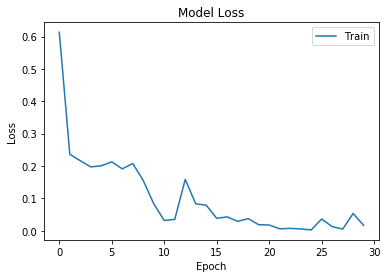

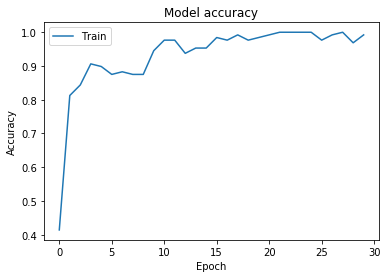

In [4]:
# output = classifier.predict_generator(test_set, steps=1)
# print(test_set.class_indices)
# print(output)
size = y_test[:,-1]
print(size.size)


# predict 10 random hand-writing data
y_predicted = model.predict(x_test)
y_predicted = np.array(y_predicted,dtype=np.float32)
for x in range(0,size.size):
    
    print("index:", x,
          " actual y:", np.argmax(y_test[x]),
          " answer y:", np.argmax(y_predicted[x]),
            " prediction:", np.array(y_predicted[x]))

evaluation = model.evaluate(x_test, y_test)
print('loss: ', evaluation[0])
print('accuracy', evaluation[1])


import matplotlib.pyplot as plt

# 손실 그래프
def plot_loss(history):
   # 선 그리기
   plt.plot(history.history['loss'])
   # 그래프 제목
   plt.title('Model Loss')
   # x,y축 이름 표시
   plt.ylabel('Loss')
   plt.xlabel('Epoch')
   # 각 라인 표식 표시
   plt.legend(['Train','Test'],loc=0)

# 정확도 그래프
def plot_acc(history):
  # dir(history.history)
   plt.plot(history.history['accuracy'])
   plt.title('Model accuracy')
   plt.ylabel('Accuracy')
   plt.xlabel('Epoch')
   plt.legend(['Train', 'Test'], loc=0)

plot_loss(history)
plt.show()
plot_acc(history)
plt.show()

In [5]:
# batch_size = [128,256,512,1024]
# learning_rate = [0.001,0.0001,0.00001,0.000001]
# for  batch_size, learning_rate in product(batch_size,learning_rate):
#     print(f'batchSIZE is {batch_size}, Learning Rate is {learning_rate}')
#     train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

#     test_datagen = ImageDataGenerator(rescale = 1./255)

#     categories = ['dog','cat','bear','hamster']

#     training_set = train_datagen.flow_from_directory(train_img_dir, target_size=(128,128), 
#                                                  classes=categories, 
#                                                  batch_size=batch_size)

#     test_set = test_datagen.flow_from_directory(test_img_dir,
#                                             target_size=(128,128), 
#                                             classes=categories, 
#                                             batch_size=batch_size)



#     x_train, y_train = next(training_set)
#     x_test, y_test = next(test_set)
#     model = mobile_net()
#     ## learning rate scheduing
#     lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
#                                                               decay_steps=training_epochs*10,
#                                                               decay_rate=0.4,
#                                                               staircase=True)
#     ## optimizer는 Adam, loss는 sparse categorical crossentropy 사용
#     ## label이 ont-hot으로 encoding 안 된 경우에 sparse categorical corssentropy 및 sparse categorical accuracy 사용
#     model.compile(keras.optimizers.Adam(lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

#     ## Train!
#     model.fit(x_train, y_train, steps_per_epoch=training_epochs,
#              epochs=12)
#     # output = classifier.predict_generator(test_set, steps=1)
#     # print(test_set.class_indices)
#     # print(output)
#     size = y_test[:,-1]
#     print(size.size)


#     # predict 10 random hand-writing data
#     y_predicted = model.predict(x_test)
#     for x in range(0,size.size):

#         print("index:", x,
#               " actual y:", np.argmax(y_test[x]),
#               " answer y:", np.argmax(y_predicted[x]),
#                 " prediction:", np.array(y_predicted[x]))

#     evaluation = model.evaluate(x_test, y_test)
#     print('loss: ', evaluation[0])
#     print('accuracy', evaluation[1])

